# **Sub-system 2: Trend Recommending Subsystem**

# **1. Objective**

Subsystem 2 is responsible for:
- Discovering latent topics from Twitter data using semantic embeddings
- Clustering semantically similar tweets
- Detecting emerging trends over time
- Assigning a quantitative trend score per topic

Unlike rule-based keyword grouping, this subsystem uses BERT-based embeddings to capture contextual meaning.

**1.1 Load the Dataset**

In [48]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("mcantoni81/twitter-dataset-the-intel-raptor-release")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\User\.cache\kagglehub\datasets\mcantoni81\twitter-dataset-the-intel-raptor-release\versions\1


In [49]:
import pandas as pd
import os

df = pd.read_csv(os.path.join(path, "intel.csv"))

In [245]:
df.head()

,Unnamed: 0,author_id,author_name,author_username,created_at,edit_history_tweet_ids,id,lang,public_metrics,text,retweet_count,like_count,period,topic_id,clean_text
0,0,499672969,fixitfixitfixit,fixitfixitfixit,2022-10-26 23:58:48+00:00,['1585420714684940288'],1585420714684940288,en,"{'retweet_count': 0, 'reply_count': 0, 'like_c...",(US)Intel Core i9-13900K Desktop Processor - O...,0,0,2022-10-26,32,US Intel Core i9-13900K Desktop Processor - Ot...
1,1,499672969,fixitfixitfixit,fixitfixitfixit,2022-10-26 23:38:26+00:00,['1585415588205236232'],1585415588205236232,en,"{'retweet_count': 0, 'reply_count': 0, 'like_c...",(US)Intel Core i9-13900K Desktop Processor - O...,0,0,2022-10-26,32,US Intel Core i9-13900K Desktop Processor - Ot...
2,2,499672969,fixitfixitfixit,fixitfixitfixit,2022-10-26 23:18:26+00:00,['1585410554197311488'],1585410554197311488,en,"{'retweet_count': 0, 'reply_count': 0, 'like_c...",(US)Intel Core i9-13900K Desktop Processor - O...,0,0,2022-10-26,32,US Intel Core i9-13900K Desktop Processor - Ot...
3,3,499672969,fixitfixitfixit,fixitfixitfixit,2022-10-26 22:58:24+00:00,['1585405512463646720'],1585405512463646720,en,"{'retweet_count': 0, 'reply_count': 0, 'like_c...",(US)Intel Core i9-13900K Desktop Processor - O...,0,0,2022-10-26,32,US Intel Core i9-13900K Desktop Processor - Ot...
4,4,499672969,fixitfixitfixit,fixitfixitfixit,2022-10-26 22:38:22+00:00,['1585400472713760768'],1585400472713760768,en,"{'retweet_count': 0, 'reply_count': 0, 'like_c...",(US)Intel Core i9-13900K Desktop Processor - O...,0,0,2022-10-26,32,US Intel Core i9-13900K Desktop Processor - Ot...


# **2. Methodology**

# **2.1 Text Preprocessing**
Tweets are cleaned before embedding to reduce noise and improve clustering quality.

Cleaning steps:
- Remove URLs
- Remove @mentions
- Preserve hashtag text (remove only #)
- Remove HTML artifacts
- Normalize whitespace
- Remove duplicate tweets

This ensures embeddings reflect semantic content rather than formatting noise.

In [51]:
import re

def clean_for_bert(text: str) -> str:
    if text is None:
        return ""
    text = str(text)

    # Remove URLs
    text = re.sub(r"http\S+|www\.\S+", " ", text)

    # Remove @mentions and keep hashtags text (remove only #)
    text = re.sub(r"@\w+", " ", text)
    text = text.replace("#", "")

    # Remove HTML entities/tags
    text = re.sub(r"<.*?>", " ", text)
    text = text.replace("&amp;", "and")

    # Keep letters/numbers/basic punctuation; remove weird symbols
    text = re.sub(r"[^\w\s\.\,\!\?\-\'\"]+", " ", text)

    # Normalize whitespace
    text = re.sub(r"\s+", " ", text).strip()

    return text

In [107]:
df["clean_text"] = df["text"].apply(clean_for_bert)

In [109]:
df = df.drop_duplicates(subset=["clean_text"])
df = df.reset_index(drop=True)

# **2.2 Semantic Embedding (BERT)**
We use a sentence-level transformer model: **all-MiniLM-L6-v2**

Each tweet is converted into a dense semantic vector.

This allows:
- Context-aware similarity
- Better separation of different topics
- Improved clustering quality compared to bag-of-words methods

In [113]:
from sentence_transformers import SentenceTransformer
import numpy as np

texts = df["clean_text"].astype(str).tolist()

model = SentenceTransformer("all-MiniLM-L6-v2")
embeddings = model.encode(texts, show_progress_bar=True, convert_to_numpy=True)

Loading weights:   0%|          | 0/103 [00:00<?, ?it/s]

BertModel LOAD REPORT from: sentence-transformers/all-MiniLM-L6-v2
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


Batches:   0%|          | 0/191 [00:00<?, ?it/s]

# **2.3 Topic Discovery using HDBSCAN**

Clustering is performed using HDBSCAN, a density-based algorithm.

Why HDBSCAN?
- Does not require pre-specifying number of clusters
- Handles noise effectively
- Automatically detects outliers

Output:
- Each tweet is assigned a topic_id
- Noise tweets are labelled as -1

In [208]:
import hdbscan

clusterer = hdbscan.HDBSCAN(min_cluster_size=15, min_samples=1, metric="euclidean")
labels = clusterer.fit_predict(embeddings)
df["topic_id"] = labels

C:\Users\User\anaconda3\envs\bert_jupyter\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


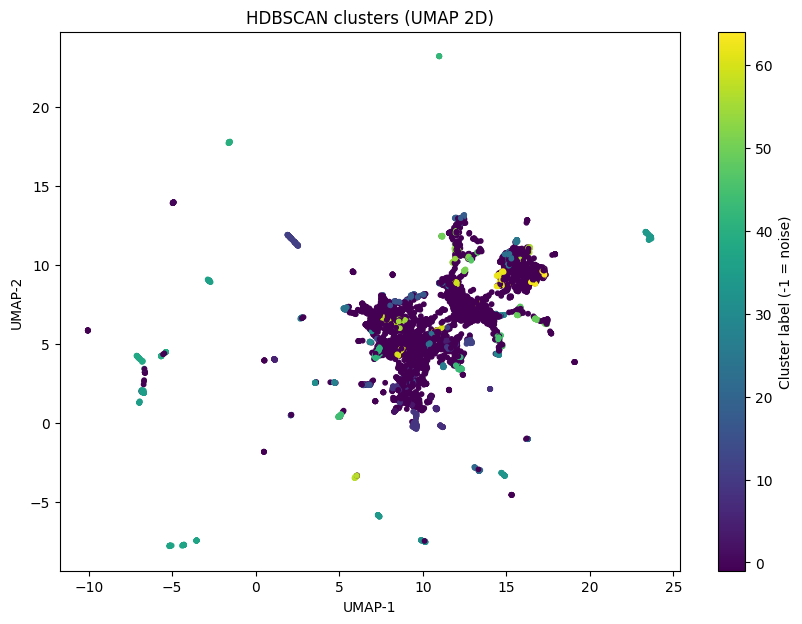

Clusters found (excluding noise): 65
Noise points: 3981


In [209]:
import matplotlib.pyplot as plt
import umap

reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, metric="cosine", random_state=42)
emb_2d = reducer.fit_transform(embeddings)

plt.figure(figsize=(10, 7))
scatter = plt.scatter(emb_2d[:, 0], emb_2d[:, 1], c=labels, s=10)
plt.title("HDBSCAN clusters (UMAP 2D)")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.colorbar(scatter, label="Cluster label (-1 = noise)")
plt.show()

print("Clusters found (excluding noise):", len(set(labels)) - (1 if -1 in labels else 0))
print("Noise points:", np.sum(labels == -1))

# **2.4 Topic Interpretation**
For each cluster:
- Tweets belonging to the cluster are grouped
- TF-IDF is applied to extract representative keywords
- Example tweets are displayed for qualitative validation

This step ensures topic coherence and interpretability.

In [259]:
# df must contain: clean_text, topic_id
df_topics = df[df["topic_id"] != -1].copy()  # remove noise

# One big document per topic
topic_docs = (
    df_topics.groupby("topic_id")["clean_text"]
    .apply(lambda x: " ".join(x.astype(str)))
    .reset_index()
)

topic_docs.head()

,topic_id,clean_text
0,0,Intel RealSense Depth Camera D435 フルトラッキング ボディ...
1,1,"Intel, Tesla, CATL La ruee des industriels ver..."
2,2,ALSO TODAY INTEL ASSHOLES ARE KEEPING MY SHOUL...
3,3,Intel CEO Taiwan's Place in Tech Industry Is '...
4,4,RT Experience exceptional clarity and vividnes...


In [261]:
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

# Count words per topic-document
vectorizer = CountVectorizer(
    stop_words="english",
    ngram_range=(1, 2),
    min_df=2
)
X_counts = vectorizer.fit_transform(topic_docs["clean_text"])

# Convert counts -> TF-IDF
tfidf = TfidfTransformer(norm=None)  # norm=None is common in c-TF-IDF style
X_tfidf = tfidf.fit_transform(X_counts)

terms = np.array(vectorizer.get_feature_names_out())

In [269]:
def top_words_per_topic(X_tfidf, topic_ids, terms, top_n=10):
    out = {}
    for row_i, topic in enumerate(topic_ids):
        row = X_tfidf[row_i].toarray().ravel()
        top_idx = row.argsort()[-top_n:][::-1]
        out[int(topic)] = terms[top_idx].tolist()
    return out

topic_ids = topic_docs["topic_id"].tolist()
topic_keywords = top_words_per_topic(X_tfidf, topic_ids, terms, top_n=10)

for t in sorted(topic_keywords)[:65]:
    print(f"Topic {t}: {', '.join(topic_keywords[t])}")

Topic 0: 2022 10, depth, 2022, 10, intel, 23, 29, 10 22, 22, 10 23
Topic 1: die, der, 2022, ibm, samsung, hp, google, microsoft, innovation, apple
Topic 2: intel, order, right, keeping, prevent, ful, break, place, make, smartphone
Topic 3: ceo, intel ceo, chip, intel, chips, manufacturing, industry, fintwit intel, fintwit, india
Topic 4: diwali, asus, ultra, laptops, laptop, intel, light, technology tech, display, exceptional
Topic 5: research, scale, intel, ai, cpus, performance, labs, intel labs, large, performance intel
Topic 6: intel, intc, global, company, 30, stock, debut, offering, 16, way
Topic 7: don, intel, rt, site, day, 20, today, 13, ll, facing
Topic 8: ai, intel, intel ai, labs, intel labs, ai intel, vision, hardware, applications, computer
Topic 9: intc, intc intc, intel intc, semiconductors, ibm, chips, intel, ceo, gelsinger, pat
Topic 10: laptop, hp, lenovo, 15, dell, microsoft, intel, ssd, i3, core i3
Topic 11: rt, gt, i9 13900k, 13900k, i9, والله, usa, i5, i5 13600k,

In [273]:
for t in sorted(topic_keywords)[:5]:
    print(f"\n=== Topic {t} ===")
    examples = df_topics[df_topics["topic_id"] == t]["clean_text"].head(3).tolist()
    for ex in examples:
        print("-", ex[:180])


=== Topic 0 ===
- Intel RealSense Depth Camera D435 フルトラッキング ボディトラッキング Vtuber 2022 10 27 6 29
- Intel RealSense Depth Camera D435 フルトラッキング ボディトラッキング Vtuber 2022 10 27 0 59
- Intel RealSense Depth Camera D435 フルトラッキング ボディトラッキング Vtuber 2022 10 26 18 38

=== Topic 1 ===
- Intel, Tesla, CATL La ruee des industriels vers l'est de l'Allemagne Intel a annonce en mars 2022 un investissement de 17 milliards d'Euros a Magdebourg Saxe-Anhalt pour construire
- RT Die innovativsten Unternehmen der Welt BCG Most Innovative Companies 2022 MIC22 Bosch Intel
- Die innovativsten Unternehmen der Welt BCG Most Innovative Companies 2022 MIC22 Bosch Intel Microsoft Cisco Apple DigitaleTransformation TikTok Zalando IBM Studie Samsung SAP BCG H

=== Topic 2 ===
- ALSO TODAY INTEL ASSHOLES ARE KEEPING MY SHOULDERS JOINTS and RIGHT THUMB BLOCKED and PAIN-FUL IN ORDER TO MAKE ME NOT SELFSUFFICIENT THEY'RE I.A. UNLEASHING ELECTROMAGNETIC ASSAUL
- INTEL TURDS ARE AGAIN HACKING OUR PHONES and WIRING IN ORDER TO RE

In [211]:
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import defaultdict

# group docs by topic
topic_docs = defaultdict(list)
for t, lab in zip(texts, labels):
    if lab != -1:  # ignore noise
        topic_docs[lab].append(t)

# TF-IDF over all docs, then get top words per topic
vectorizer = TfidfVectorizer(
    stop_words="english",
    max_features=5000,
    ngram_range=(1, 2)
)
X = vectorizer.fit_transform(texts)
terms = np.array(vectorizer.get_feature_names_out())

topic_keywords = {}
for lab, docs in topic_docs.items():
    idxs = [i for i, l in enumerate(labels) if l == lab]
    avg_tfidf = X[idxs].mean(axis=0).A1
    top = avg_tfidf.argsort()[-10:][::-1]
    topic_keywords[lab] = terms[top].tolist()

# show topics
for lab in sorted(topic_keywords):
    print(f"\nTopic {lab}: {', '.join(topic_keywords[lab])}")



Topic 0: ボディトラッキング, realsense, realsense depth, フルトラッキング ボディトラッキング, フルトラッキング, camera, d435 フルトラッキング, vtuber 2022, d435, ボディトラッキング vtuber

Topic 1: bcg, companies 2022, innovative companies, innovative, companies, die innovativsten, mic22, innovativsten, unternehmen der, unternehmen

Topic 2: exposetheperp, targetedindividuals, pain, inducing, torture, tortured, shoulders, assaults, joints, shoulders joints

Topic 3: china, ceo, intel ceo, chip, restrictions, inevitable, china inevitable, calls, intel, manufacturing

Topic 4: diwali, asus, asusindia, vivobook, wowtheworld, asus vivobook, laptops, laptops intel, ultra, laptop

Topic 5: graph, neural, training, graph neural, optimizing, research, graph training, scale, neural graph, ai

Topic 6: mobileye, ipo, intel mobileye, mobileye ipo, intel, driving, autonomous, unit, mbly, billion

Topic 7: intelafricamasters, intelgaming, finals, csgo, intelafricamasters intelgaming, tune, regional, regional finals, rt, intelgaming intel

Topic 8:

In [212]:
for lab in sorted(topic_docs.keys())[:5]:  # first 5 topics
    print(f"\n=== Topic {lab} ===")
    for ex in topic_docs[lab][:3]:
        print("-", ex[:160])


=== Topic 0 ===
- Intel RealSense Depth Camera D435 フルトラッキング ボディトラッキング Vtuber 2022 10 27 6 29
- Intel RealSense Depth Camera D435 フルトラッキング ボディトラッキング Vtuber 2022 10 27 0 59
- Intel RealSense Depth Camera D435 フルトラッキング ボディトラッキング Vtuber 2022 10 26 18 38

=== Topic 1 ===
- Intel, Tesla, CATL La ruee des industriels vers l'est de l'Allemagne Intel a annonce en mars 2022 un investissement de 17 milliards d'Euros a Magdebourg Saxe-An
- RT Die innovativsten Unternehmen der Welt BCG Most Innovative Companies 2022 MIC22 Bosch Intel
- Die innovativsten Unternehmen der Welt BCG Most Innovative Companies 2022 MIC22 Bosch Intel Microsoft Cisco Apple DigitaleTransformation TikTok Zalando IBM Stud

=== Topic 2 ===
- ALSO TODAY INTEL ASSHOLES ARE KEEPING MY SHOULDERS JOINTS and RIGHT THUMB BLOCKED and PAIN-FUL IN ORDER TO MAKE ME NOT SELFSUFFICIENT THEY'RE I.A. UNLEASHING EL
- INTEL TURDS ARE AGAIN HACKING OUR PHONES and WIRING IN ORDER TO REMOTELY BROWSE ON THEM and PREVENT THEM FROM RECHARGING THEY 

# **2.4.1 Evaluation of Topics**

This is a comparison of regular TF-IDF vs BERTopic

There is an overall structural difference.

**BERTopic**
- Many noisy numeric tokens (10 22, 2022, 10 23)
- Some clusters are messy
- Several clusters look repetitive
- Some topics look fragmented (very similar topics repeated)

Many repeated topics on links, associate earn, qualifying purchases.

**TF-IDF**

A lot cleaner in comparison. 

Example: 
- Clear IPO topic in topic 6.
- Clear RAM topic in topic 16.

This allows for ease of interpretability.

**Important Observation**

There are many Amazon affiliate clusters across topics 31-40 for both outputs. 

The dataset contains heavy promotional noise and should be filtered to improve clustering quality.

**Comparison Conclusion**

For this prototype, TF-IDF is preferred as it is:
- More interpretable
- Better grouped
- Cleaner for reporting

# **3. Trend Detection Framework**
After topics are discovered, trend scoring is applied.

Trend analysis is performed on a daily time period.

# **3.1 Daily Topic Volume**
For each topic:
mentions_this_period = count of tweets per topic per day


In [214]:
df["created_at"] = pd.to_datetime(df["created_at"], errors="coerce")
df = df.dropna(subset=["created_at"])
df["period"] = df["created_at"].dt.date   # daily period

In [215]:
daily_mentions = (
    df[df["topic_id"] != -1]
      .groupby(["topic_id", "period"])
      .size()
      .reset_index(name="mentions_this_period")
      .sort_values(["topic_id", "period"])
)

daily_mentions["mentions_last_period"] = (
    daily_mentions.groupby("topic_id")["mentions_this_period"].shift(1)
)

# **3.2 Volume Growth Rate**

Volume_growth = (mentions_this_period  - mentions_last_period) / mentions_last_perio

If previous mentions are zero or missing, growth is set to 0.d 

In [217]:
m_last = daily_mentions["mentions_last_period"]

daily_mentions["volume_growth"] = np.where(
    (m_last.isna()) | (m_last <= 0),
    0.0,
    (daily_mentions["mentions_this_period"] - m_last) / m_last
)

# **3.3 Novelty Score**

A topic is considered novel if:
- It appears for the first time in the dataset

In [219]:
daily_mentions["novelty_score"] = (
    daily_mentions["mentions_last_period"].isna()
).astype(int)

# **3.4 Engagement Score**

If engagement metadata exists: Engagement_score = mean(retweet_count + like_count)

This captures user interaction intensity.

In [221]:
if {"retweet_count", "like_count"}.issubset(df.columns):
    daily_engagement = (
        df[df["topic_id"] != -1]
          .groupby(["topic_id", "period"])
          .apply(lambda g: (g["retweet_count"] + g["like_count"]).mean())
          .reset_index(name="engagement_score")
    )
    daily_mentions = daily_mentions.merge(daily_engagement, on=["topic_id", "period"], how="left")
else:
    daily_mentions["engagement_score"] = 0.0

C:\Users\User\AppData\Local\Temp\ipykernel_14664\62632708.py:5: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: (g["retweet_count"] + g["like_count"]).mean())


# **3.5 Final Trend Score**
Trend score is computed using weighted components:

Trend_score =
W1 × volume_growth_norm + W2 × engagement_score + W3 × novelty_score

Weights used:
- W1 = 0.6 (growth importance)
- W2 = 0.3 (engagement importance)
- W3 = 0.1 (novelty importance)

Final score is clamped to [0, 1].

Topics with Trend_score ≥ 0.7 are classified as trending.  

In [223]:
# Weights
W1, W2, W3 = 0.6, 0.3, 0.1 

# normalize growth (recommended)
daily_mentions["volume_growth_norm"] = np.tanh(daily_mentions["volume_growth"])

raw = (
    W1 * daily_mentions["volume_growth_norm"] +
    W2 * daily_mentions["engagement_score"] +
    W3 * daily_mentions["novelty_score"]
)

daily_mentions["trend_score"] = np.clip(raw, 0, 1)

In [224]:
daily_mentions["is_trending"] = (daily_mentions["trend_score"] >= 0.7).astype(int)

# Top 5 topics for the latest day
latest_day = daily_mentions["period"].max()
top_today = daily_mentions[daily_mentions["period"] == latest_day].sort_values("trend_score", ascending=False).head(5)
top_today

,topic_id,period,mentions_this_period,mentions_last_period,volume_growth,novelty_score,engagement_score,volume_growth_norm,trend_score,is_trending
89,14,2022-10-26,1,20.0,-0.950000,0,6.000000,-0.739783,1.000000,1
29,4,2022-10-26,5,1.0,4.000000,0,8.800000,0.999329,1.000000,1
137,24,2022-10-26,2,1.0,1.000000,0,26.500000,0.761594,1.000000,1
207,41,2022-10-26,4,2.0,1.000000,0,10.250000,0.761594,1.000000,1
72,11,2022-10-26,22,6.0,2.666667,0,1.272727,0.990390,0.976052,1


# **3.6 Evaluation of Trend Score**

Trending scores are calculated on a daily basis.

Observation from top 5 trend score reveals that everything is trending.

This happens even when volumn growth shows a negative number of -0.95 which does not seem logical.

**Possible reasons:**
- Too much weightage to engagement score